## Contextualização

Baseado no dataset disponível em: https://www.kaggle.com/datasets/srgiolutzer/limite-de-crdito-bancrio/data, promover um entendimento das variáveis e, identifique os insights mais valiosos para compartilhar com o time de Data Science pensando na utilização em modelos estatísticos de propensão à crédito.

## Importação das bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Importação do dataset

In [2]:

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d srgiolutzer/limite-de-crdito-bancrio -f credito.csv


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/srgiolutzer/limite-de-crdito-bancrio
License(s): DbCL-1.0
100% 880k/880k [00:00<00:00, 2.42MB/s]
100% 880k/880k [00:00<00:00, 2.41MB/s]


In [3]:
df = pd.read_csv('credito.csv')

##ETL (Extract, Transform and Load)

In [4]:
df.dtypes

,0
id,int64
default,int64
idade,int64
sexo,object
dependentes,int64
escolaridade,object
estado_civil,object
salario_anual,object
tipo_cartao,object
meses_de_relacionamento,int64


Convertendo para float as colunas com valores numéricos

In [5]:
df['salario_anual'] = df['salario_anual'].replace('na', None)
df['limite_credito'] = pd.to_numeric(df['limite_credito'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
df['valor_transacoes_12m'] = pd.to_numeric(df['valor_transacoes_12m'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
df['dependentes'] = pd.Categorical(df['dependentes'])
df['meses_de_relacionamento'] = pd.Categorical(df['meses_de_relacionamento'])
df['meses_inativo_12m'] = pd.Categorical(df['meses_inativo_12m'])
df['qtd_produtos'] = pd.Categorical(df['qtd_produtos'])
df['iteracoes_12m'] = pd.Categorical(df['iteracoes_12m'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       10127 non-null  int64   
 1   default                  10127 non-null  int64   
 2   idade                    10127 non-null  int64   
 3   sexo                     10127 non-null  object  
 4   dependentes              10127 non-null  category
 5   escolaridade             10127 non-null  object  
 6   estado_civil             10127 non-null  object  
 7   salario_anual            9015 non-null   object  
 8   tipo_cartao              10127 non-null  object  
 9   meses_de_relacionamento  10127 non-null  category
 10  qtd_produtos             10127 non-null  category
 11  iteracoes_12m            10127 non-null  category
 12  meses_inativo_12m        10127 non-null  category
 13  limite_credito           10127 non-null  float64 
 14  valor_

Vamos avaliar o histograma das variáveis para entender o comportamento das distribuições:

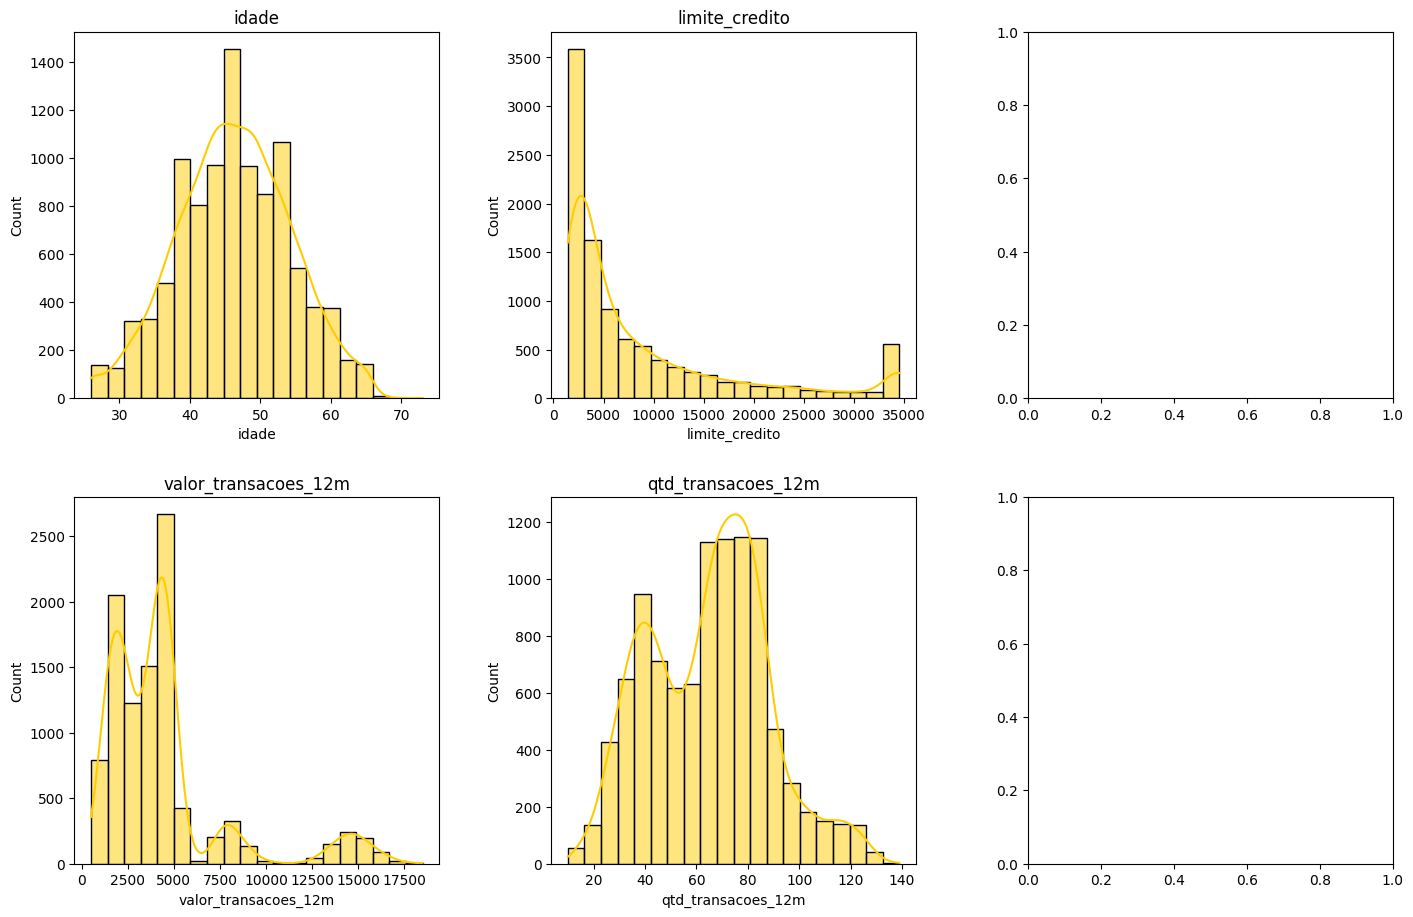

In [7]:
numeric_cols = df.select_dtypes(include=['number']).drop(['id','default'], axis=1).columns

num_cols = len(numeric_cols)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
fig.tight_layout(pad=5.0)

for i, col in enumerate(numeric_cols):
  row = i // 2
  col_idx = i % 2
  ax = axes[row, col_idx]
  sns.histplot(df[col].dropna(), bins=20, kde=True, color='#FFCC00', ax=ax)
  ax.set_title(col)

for i in range(len(numeric_cols), num_rows * 2):
  row = i // 2
  col_idx = i % 2
  fig.delaxes(axes[row, col_idx])

plt.show()

Podemos ver que a variável idade segue uma distribuição normal com os clientes possuindo 45 anos em média. Já a variável limite_credito apresenta uma distribuição assimétrica com grande concentração dos clientes possuindo limites até 5K, porém também destacamos um outlier em torno de 35K, requerendo atenção especial (que características essa parcela do público possui fazendo o modelo estatístico positivá-la tanto ?).

Quanto aos valores nulos, notamos que das três colunas (escolaridade, estado_civil, salario_anual) onde temos essa condição, o maior potencial de perda de informação seria referente à renda, portanto verificou-se que existem 1.112 registros nulos na coluna "salario_anual" e, que foram substituídos pela quantidade média de ocorrências agrupada pelos valores não nulos de escolaridade

In [8]:
grouped_mean_salary = df.groupby(['escolaridade'])['salario_anual'].agg(lambda x: x.mode()[0] if not x.isnull().all() else None)

mean_salary_mapping = grouped_mean_salary.to_dict()

def fill_missing_salary(row):
  if pd.isnull(row['salario_anual']):
    if (row['escolaridade']) in mean_salary_mapping:
      return mean_salary_mapping[(row['escolaridade'])]
  return row['salario_anual']

df['salario_anual'] = df.apply(fill_missing_salary, axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       10127 non-null  int64   
 1   default                  10127 non-null  int64   
 2   idade                    10127 non-null  int64   
 3   sexo                     10127 non-null  object  
 4   dependentes              10127 non-null  category
 5   escolaridade             10127 non-null  object  
 6   estado_civil             10127 non-null  object  
 7   salario_anual            10127 non-null  object  
 8   tipo_cartao              10127 non-null  object  
 9   meses_de_relacionamento  10127 non-null  category
 10  qtd_produtos             10127 non-null  category
 11  iteracoes_12m            10127 non-null  category
 12  meses_inativo_12m        10127 non-null  category
 13  limite_credito           10127 non-null  float64 
 14  valor_

##EDA (Exploratory Data Analysis

Verificando o comportamento das categorias da coluna "Escolaridade" frente às colunas numéricas para cogitar a unificação das categorias "**na**" e "**sem educacao formal**"

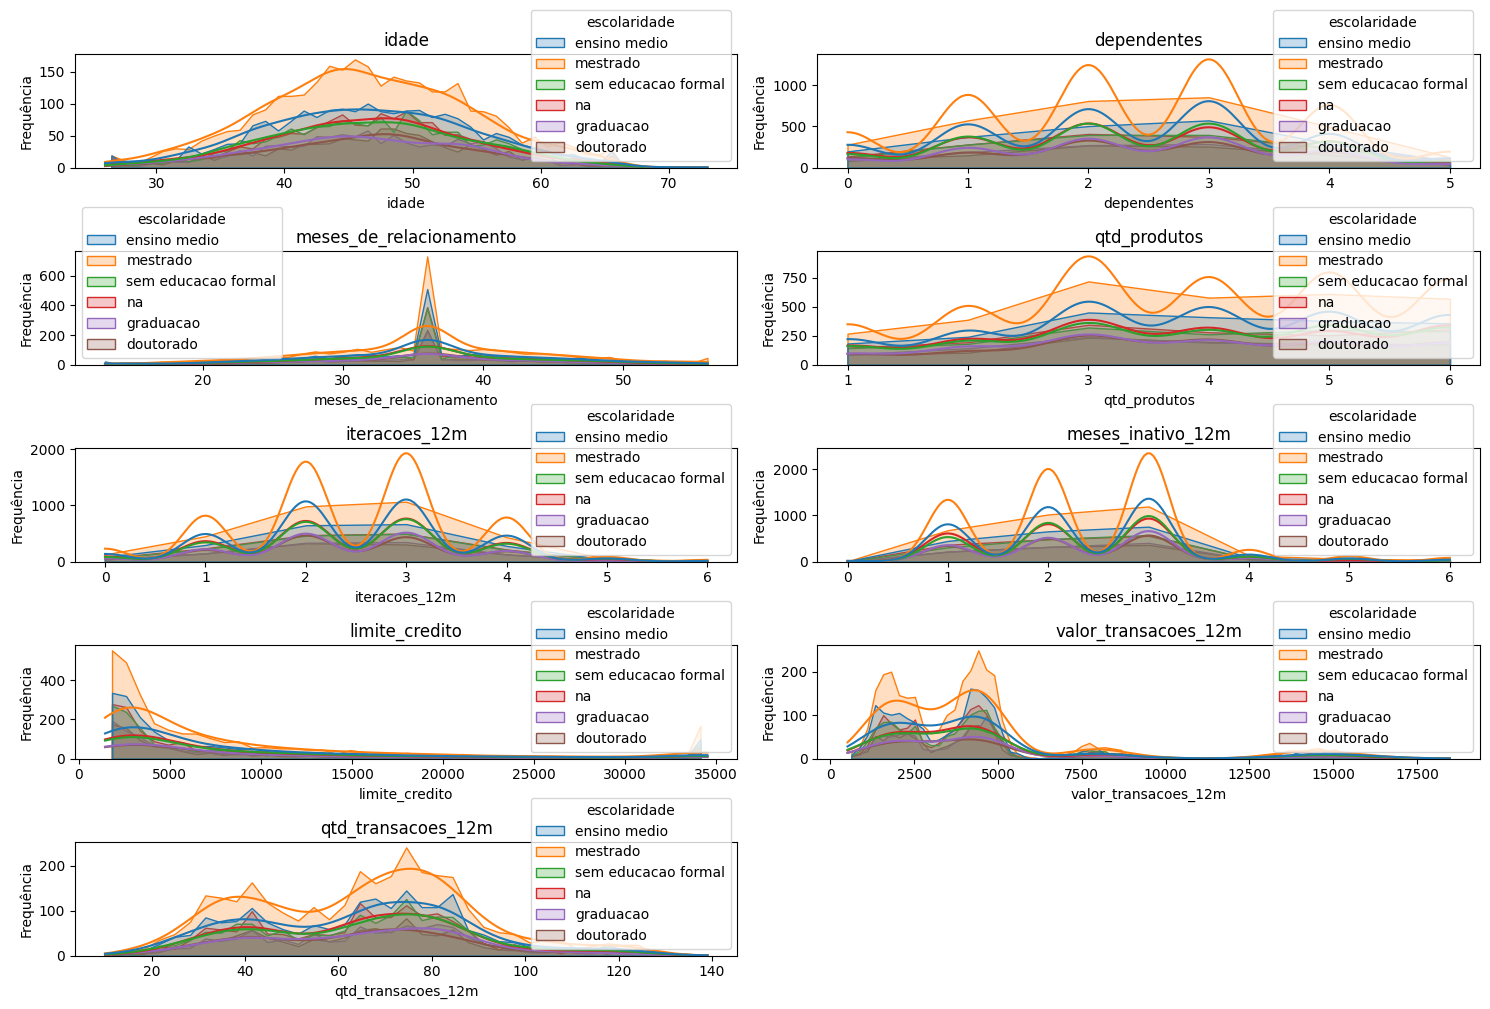

In [21]:
numerical_cols = ['idade', 'dependentes', 'meses_de_relacionamento', 'qtd_produtos', 'iteracoes_12m', 'meses_inativo_12m', 'limite_credito', 'valor_transacoes_12m', 'qtd_transacoes_12m']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 2, i + 1)
    sns.histplot(data=df, x=col, hue='escolaridade', kde=True, element="poly")
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
plt.tight_layout()
plt.xlabel(col)
plt.ylabel('Frequência')

for i in range(len(numerical_cols), num_rows * 2):
  row = i // 2
  col_idx = i % 2
  fig.delaxes(axes[row, col_idx])

plt.show()

Portanto, substituindo "na" por "sem educacao formal" na coluna escolaridade

In [22]:
df['escolaridade'] = df['escolaridade'].replace('na', 'sem educacao formal')

Para as variáveis categóricas, foram testados agrupamentos entre seus valores

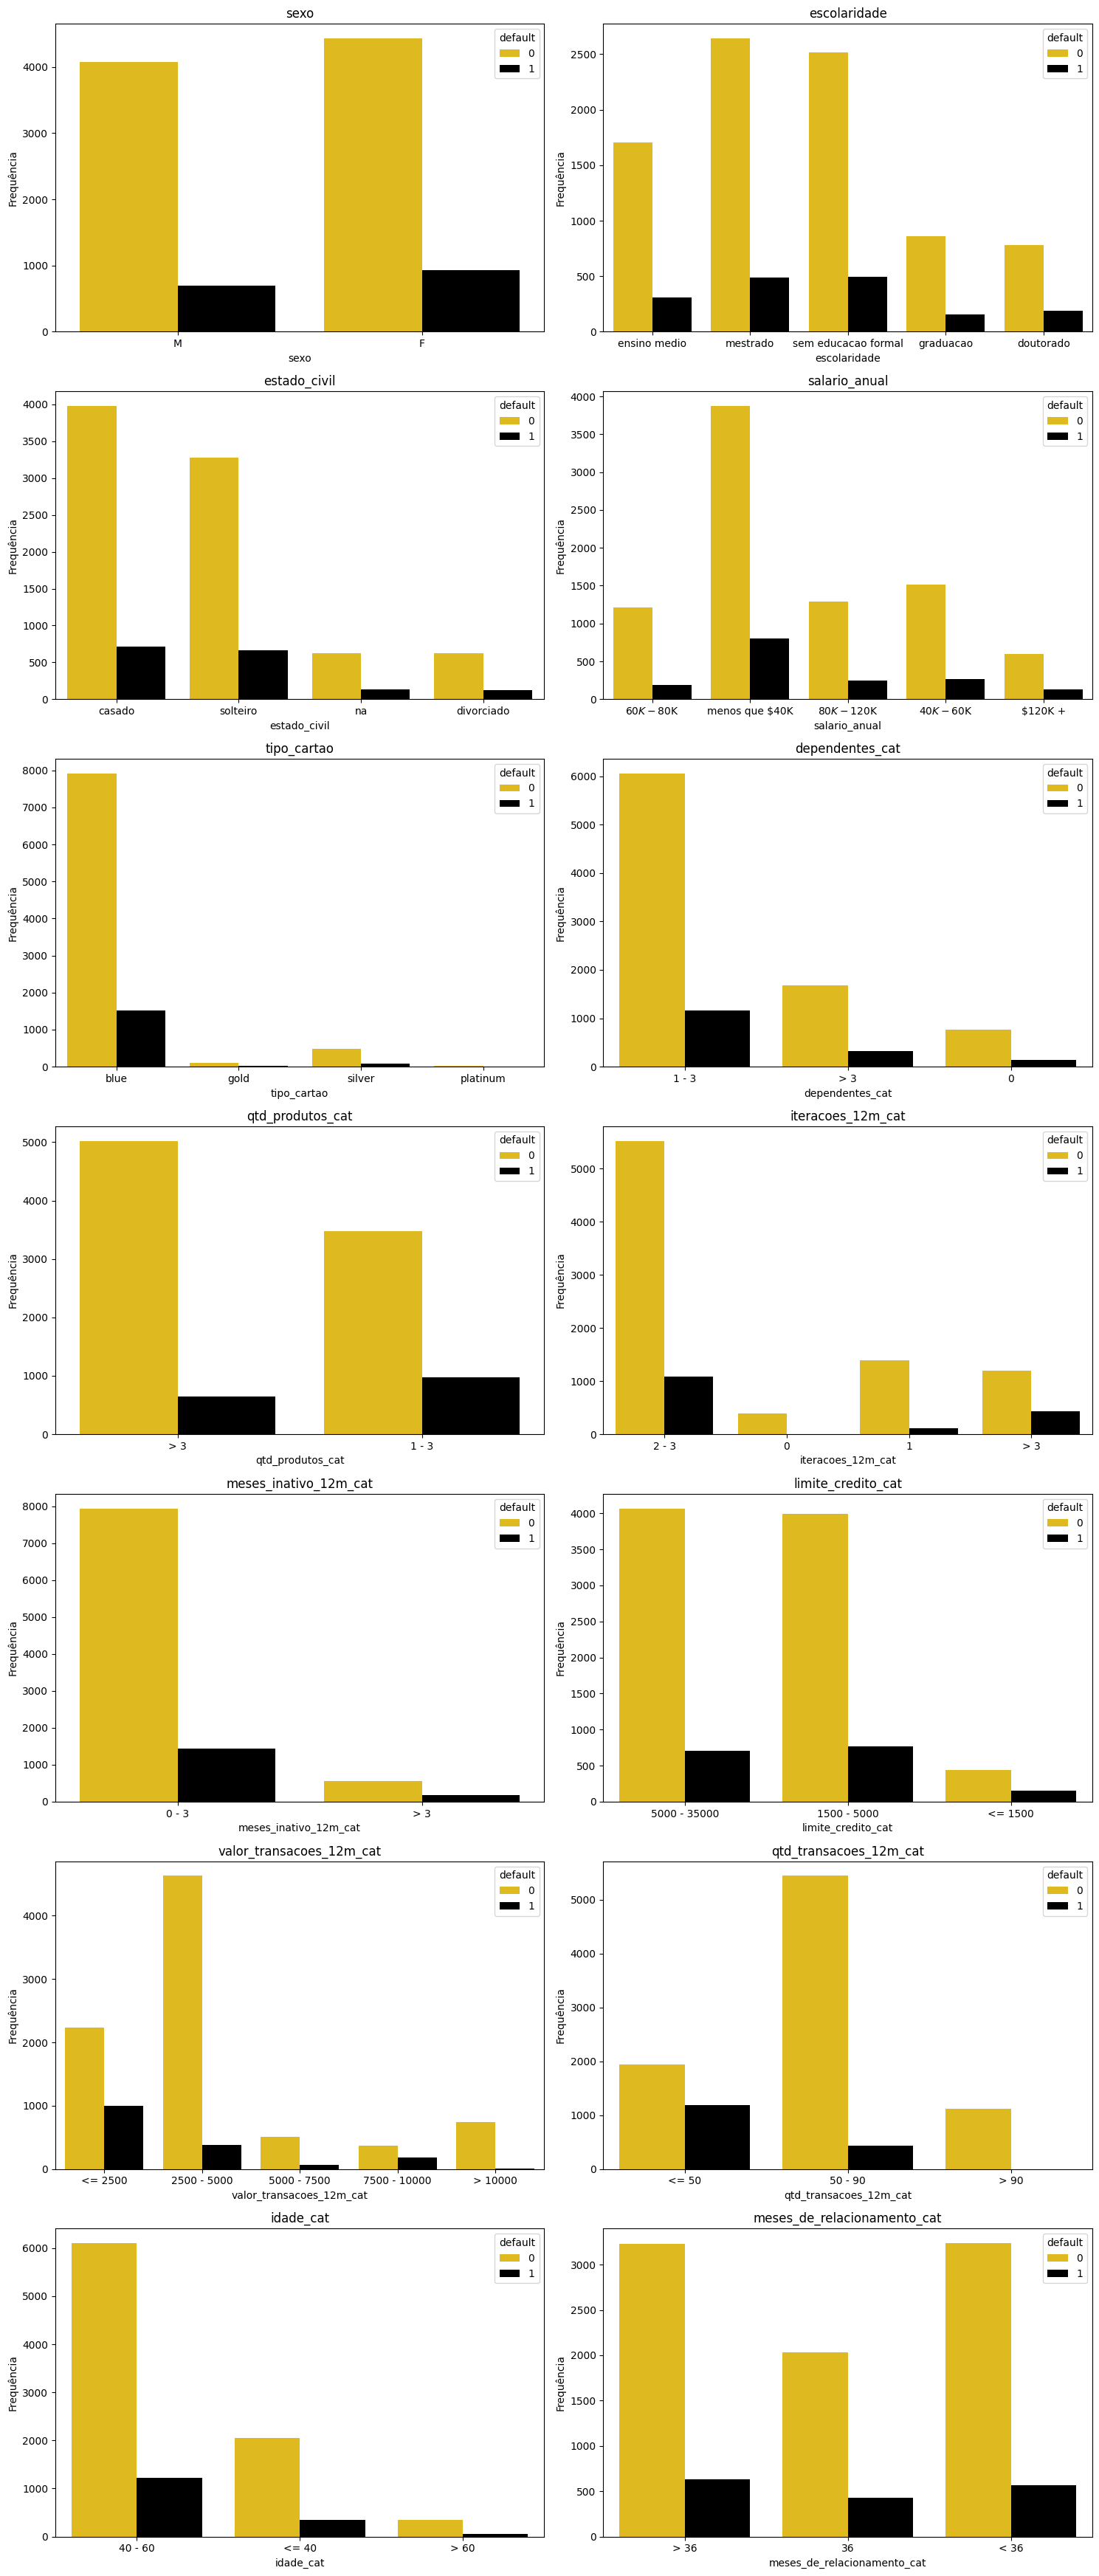

In [25]:
def categorize_dependentes(value):
  if value == 0:
    return '0'
  elif value >= 1 and value <= 3:
    return '1 - 3'
  else:
    return '> 3'

def categorize_qtd_produtos(value):
  if value <= 3:
    return '1 - 3'
  else:
    return '> 3'

def categorize_iteracoes_12m(value):
  if value == 0:
    return '0'
  elif value == 1:
    return '1'
  elif value >= 2 and value <= 3:
    return '2 - 3'
  else:
    return '> 3'

def categorize_meses_inativo_12m(value):
  if value <= 3:
    return '0 - 3'
  else:
    return '> 3'

def categorize_limite_credito(value):
  if value <= 1500:
    return '<= 1500'
  elif value > 1500 and value <= 5000:
    return '1500 - 5000'
  elif value > 5000 and value <= 35000:
    return '5000 - 35000'
  else:
    return '> 35000'

def categorize_valor_transacoes_12m(value):
  if value <= 2500:
    return '<= 2500'
  elif value > 2500 and value <= 5000:
    return '2500 - 5000'
  elif value > 5000 and value <= 7500:
    return '5000 - 7500'
  elif value > 7500 and value <= 10000:
    return '7500 - 10000'
  else:
    return '> 10000'

def categorize_qtd_transacoes_12m(value):
  if value <= 50:
    return '<= 50'
  elif value > 50 and value <= 90:
    return '50 - 90'
  else:
    return '> 90'

def categorize_idade(value):
  if value <= 40:
    return '<= 40'
  elif value > 40 and value <= 60:
    return '40 - 60'
  else:
    return '> 60'

def categorize_meses_de_relacionamento(value):
  if value < 36:
    return '< 36'
  elif value == 36:
    return '36'
  else:
    return '> 36'

df['dependentes_cat'] = df['dependentes'].apply(categorize_dependentes)
df['qtd_produtos_cat'] = df['qtd_produtos'].apply(categorize_qtd_produtos)
df['iteracoes_12m_cat'] = df['iteracoes_12m'].apply(categorize_iteracoes_12m)
df['meses_inativo_12m_cat'] = df['meses_inativo_12m'].apply(categorize_meses_inativo_12m)
df['limite_credito_cat'] = df['limite_credito'].apply(categorize_limite_credito)
df['valor_transacoes_12m_cat'] = df['valor_transacoes_12m'].apply(categorize_valor_transacoes_12m)
df['qtd_transacoes_12m_cat'] = df['qtd_transacoes_12m'].apply(categorize_qtd_transacoes_12m)
df['idade_cat'] = df['idade'].apply(categorize_idade)
df['meses_de_relacionamento_cat'] = df['meses_de_relacionamento'].apply(categorize_meses_de_relacionamento)

df_copy = df.loc[:, ~df.columns.isin(['dependentes','qtd_produtos','iteracoes_12m','meses_inativo_12m','limite_credito', 'valor_transacoes_12m', 'qtd_transacoes_12m', 'idade', 'meses_de_relacionamento'])].copy()

num_cols = len(df_copy.columns) - 2
num_rows = (num_cols + 1) // 2

plt.figure(figsize=(15, 5 * num_rows))

subplot_index = 1

for i, col in enumerate(df_copy.columns):
  if col != 'id' and col != 'default':
    plt.subplot(num_rows, 2, subplot_index)
    sns.countplot(data=df_copy, x=col, hue='default', palette={0: '#FFCC00', 1: 'black'})
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    subplot_index += 1

plt.tight_layout()
plt.show()

*   Quanto mais produtos contratados, menor a taxa de inadimplência;

*   Poucas interações com o banco estão relacionadas com menores taxas de ;inadimplência;

*   Maior tempo de inatividade vem acompanhada de maior inadimplência;

*   A faixa mais baixa de limite de crédito precisa de atenção especial dada a alta densidade de inadimplência;

*   Clientes que gastam menos durante o ano tendem a ser mais inadimplentes;

*   Baixo volume de transações parecem denotar maior inadimplência.

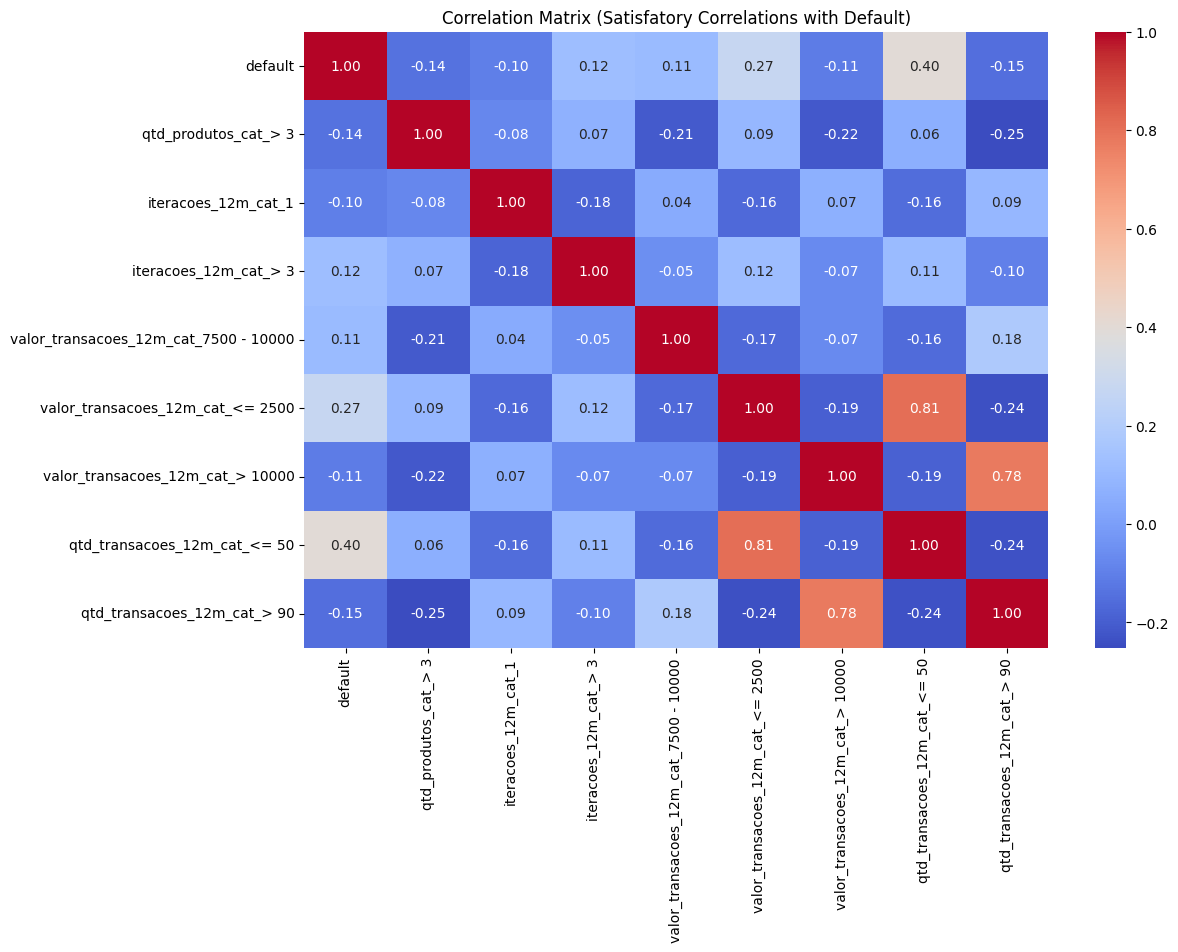

In [26]:
df_encoded = pd.get_dummies(df_copy,
                            columns=['sexo', 'escolaridade', 'estado_civil', 'salario_anual',
                                     'tipo_cartao', 'dependentes_cat', 'qtd_produtos_cat',
                                     'iteracoes_12m_cat', 'meses_inativo_12m_cat',
                                     'limite_credito_cat', 'valor_transacoes_12m_cat',
                                     'qtd_transacoes_12m_cat', 'idade_cat',
                                     'meses_de_relacionamento_cat'],
                            drop_first=True)

correlation_matrix = df_encoded.corr()

threshold = 0.1
correlation_with_default = correlation_matrix['default'].loc[(correlation_matrix['default'] > threshold) | (correlation_matrix['default'] < -threshold)]

filtered_correlation_matrix = correlation_matrix.loc[correlation_with_default.index, correlation_with_default.index]

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Satisfatory Correlations with Default)')
plt.show()

*   Quanto menos transações e de baixo valor, maior a correlação com a inadimplência;

*   Explorando o comportamento expresso pelo bullet acima, verificou-se que a relação entre quantidade de transações e o valor médio gasto é linear até certo ponto e, depois adquire uma tendência exponencial:

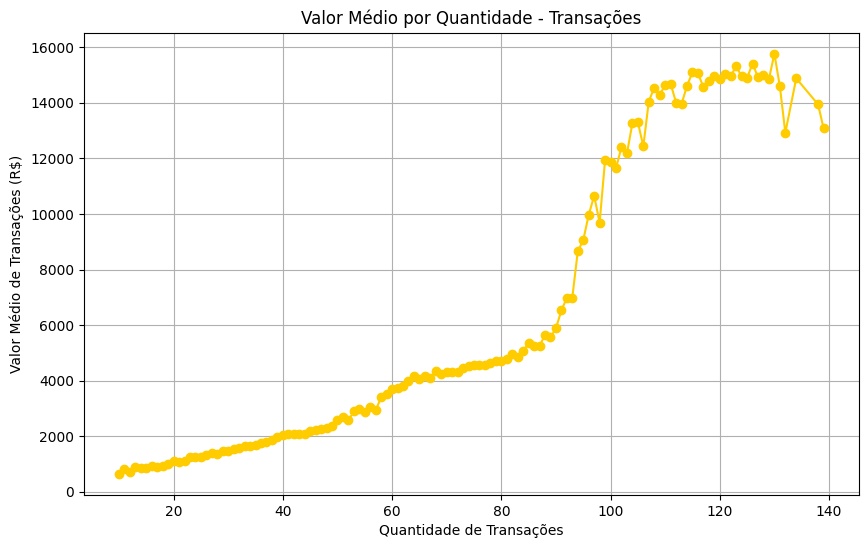

In [27]:
avg_transactions = df.groupby('qtd_transacoes_12m')['valor_transacoes_12m'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_transactions.index, avg_transactions.values, marker='o', color='#FFCC00')
plt.xlabel('Quantidade de Transações')
plt.ylabel('Valor Médio de Transações (R$)')
plt.title('Valor Médio por Quantidade - Transações')
plt.grid(True)
plt.show()

Avaliando as variáveis sob uma perspectiva de potencial utilização pelo time de modelagem estatística, o uso não parece ter potencial para melhorar indicadores do modelo (aumento de KS, estabilidade temporal, etc...):

In [28]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].shape[0],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].shape[0],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].shape[0]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']

    iv = dset['IV'].sum()

    dset = dset.sort_values(by=['WoE'])

    return dset, iv

categorical_features = ['sexo', 'escolaridade', 'estado_civil', 'salario_anual', 'tipo_cartao', 'dependentes_cat', 'qtd_produtos_cat',
                        'iteracoes_12m_cat', 'meses_inativo_12m_cat', 'limite_credito_cat', 'valor_transacoes_12m_cat',
                        'qtd_transacoes_12m_cat', 'idade_cat', 'meses_de_relacionamento_cat']

iv_values = {}

for feature in categorical_features:
    df_woe, iv = calculate_woe_iv(df_copy, feature, 'default')
    iv_values[feature] = iv

iv_df = pd.DataFrame({'Variable': list(iv_values.keys()), 'IV': list(iv_values.values())})

iv_df = iv_df.sort_values('IV', ascending=False)

display(iv_df)

,Variable,IV
11,qtd_transacoes_12m_cat,1.510341
10,valor_transacoes_12m_cat,0.853264
7,iteracoes_12m_cat,0.264278
6,qtd_produtos_cat,0.150002
9,limite_credito_cat,0.032442
8,meses_inativo_12m_cat,0.026646
0,sexo,0.010365
3,salario_anual,0.009642
1,escolaridade,0.007078
12,idade_cat,0.006951


Como pudemos ver, utilizando simplesmente as colunas do dataset original como sendo os insights, não obtivemos um resultado satisfatório. Portanto, a abordagem seguinte consistiu em combinar essas variáveis (baseado nas correlações calculadas anteriormente) para viabilizar insights mais consistentes e, novamente calculamos as métricas de WoE e IV:

In [29]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].shape[0],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].shape[0],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].shape[0]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']

    iv = dset['IV'].sum()

    dset = dset.sort_values(by=['WoE'])

    return dset, iv

categorical_features = ['sexo', 'escolaridade', 'estado_civil', 'salario_anual', 'tipo_cartao', 'dependentes_cat', 'qtd_produtos_cat',
                        'iteracoes_12m_cat', 'meses_inativo_12m_cat', 'limite_credito_cat', 'valor_transacoes_12m_cat',
                        'qtd_transacoes_12m_cat', 'idade_cat', 'meses_de_relacionamento_cat']

woe_iv_results = pd.DataFrame(columns=['Variable', 'Value', 'WoE', 'IV'])

for feature in categorical_features:
    df_woe, iv = calculate_woe_iv(df_copy, feature, 'default')
    df_woe['Variable'] = feature
    df_woe['IV'] = iv
    woe_iv_results = pd.concat([woe_iv_results, df_woe[['Variable', 'Value', 'WoE', 'IV']]])

display(woe_iv_results)

<ipython-input-29-ee49a9f1f6db>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  woe_iv_results = pd.concat([woe_iv_results, df_woe[['Variable', 'Value', 'WoE', 'IV']]])


,Variable,Value,WoE,IV
1,sexo,F,-0.092810,0.010365
0,sexo,M,0.111776,0.010365
4,escolaridade,doutorado,-0.225143,0.007078
2,escolaridade,sem educacao formal,-0.024605,0.007078
1,escolaridade,mestrado,0.037320,0.007078
3,escolaridade,graduacao,0.065488,0.007078
0,escolaridade,ensino medio,0.065579,0.007078
2,estado_civil,na,-0.083421,0.004440
1,estado_civil,solteiro,-0.063543,0.004440
3,estado_civil,divorciado,-0.008172,0.004440


In [30]:
df_final = pd.DataFrame()
df_final['default'] = df_copy['default']

# IS1
df_final['IS1'] = 0
df_final.loc[(df_copy['iteracoes_12m_cat'] == '> 3') & (df_copy['limite_credito_cat'] == '<= 1500'), 'IS1'] = 1

# IS2
df_final['IS2'] = 0
df_final.loc[(df_copy['limite_credito_cat'] == '1500 - 5000') & (df_copy['dependentes_cat'] == '1 - 3'), 'IS2'] = 1

# IS3
df_final['IS3'] = 0
df_final.loc[(df_copy['idade_cat'] == '> 60'), 'IS3'] = 1

# IS4
df_final['IS4'] = 0
df_final.loc[(df_copy['salario_anual'] == '$60K - $80K'), 'IS4'] = 1

# IS5
df_final['IS5'] = 0
df_final.loc[(df_copy['qtd_produtos_cat'] == '> 3'), 'IS5'] = 1

# IS6
df_final['IS6'] = 0
df_final.loc[(df_copy['valor_transacoes_12m_cat'] == '> 10000'), 'IS6'] = 1

# IS7
df_final['IS7'] = 0
df_final.loc[(df_copy['qtd_transacoes_12m_cat'] == '50 - 90'), 'IS7'] = 1

# IS8
df_final['IS8'] = 0
df_final.loc[(df_copy['iteracoes_12m_cat'] == '0') | (df_copy['iteracoes_12m_cat'] == '1'), 'IS8'] = 1

# IS9
df_final['IS9'] = 0
df_final.loc[(df_copy['qtd_transacoes_12m_cat'] == '<= 50') & (df_copy['valor_transacoes_12m_cat'] == '<= 2500'), 'IS9'] = 1

# IS10
df_final['IS10'] = 0
df_final.loc[(df_copy['qtd_transacoes_12m_cat'] == '> 90') & (df_copy['valor_transacoes_12m_cat'] == '> 10000'), 'IS10'] = 1


In [31]:
def calculate_woe_iv(data, feature, target):
    lst = []
    for i in range(data[feature].nunique()):
        val = list(data[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': data[data[feature] == val].count()[feature],
            'Good': data[(data[feature] == val) & (data[target] == 0)].count()[feature],
            'Bad': data[(data[feature] == val) & (data[target] == 1)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()

    return iv, dset

iv_values = []

for col in ['IS1', 'IS2', 'IS3', 'IS4', 'IS5', 'IS6', 'IS7', 'IS8', 'IS9', 'IS10']:
    iv, _ = calculate_woe_iv(df_final, col, 'default')
    iv_values.append({'Variable': col, 'IV': iv})

iv_df = pd.DataFrame(iv_values)

display(iv_df)

,Variable,IV
0,IS1,0.025820
1,IS2,0.001569
2,IS3,0.000729
3,IS4,0.006271
4,IS5,0.150002
5,IS6,0.224445
6,IS7,0.585507
7,IS8,0.173841
8,IS9,0.532835
9,IS10,inf


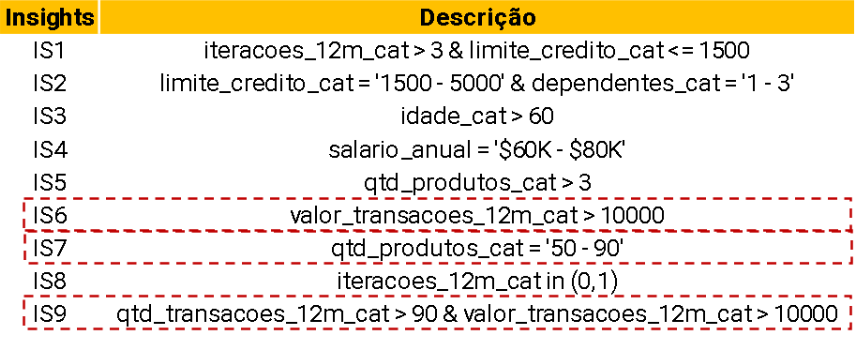

## Conclusões/Sugestões

1.   Os dados sensíveis (idade, sexo, escolaridade, dependentes, estado civil) não demonstraram significativo poder de descriminação. Mesmo que demonstrassem, valeria uma reflexão sobre o uso tendo em vista uma ponderação social não preconceituosa (como a variável sexo, por exemplo);

2.   As variáveis comportamentais de crédito (principalmente montante financeiro gasto e frequência de utilização dos produtos) mostraram-se como as mais promissoras para serem utilizadas na construção de insights (times de BA) bem como, compor o book de variáveis para construção de modelos estatísticos (times de Modelagem/Ciência de Dados). E, independente do uso, beneficiar as demais áreas através de uma melhor satisfação do cliente (time de CX), etc...

Por fim, elencamos os insights mais interessantes para serem utilizados:

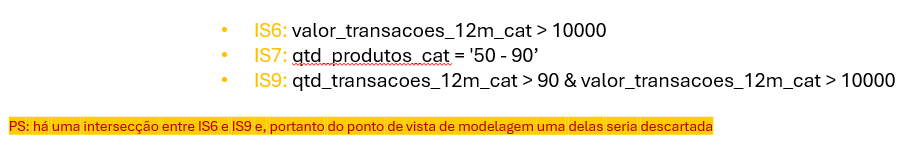

**Próximos passos:**


*   Investigar a significativa concentração de clientes com limites >= 35K (é devida ou não ?);

*   Entender mais detalhadamente como são as “interações” (pedido de dilação de prazo, aumento de limite, etc...) com o banco;

*   Refinar as categorizações das variáveis, resultando em insights mais aderentes para regras de negócio bem como, composição de book de variáveis de modelo.